# EPL VAR Analysis
## Part 2 - Analysis of Individual VAR Incidents

Refer to this for notebook examples on EDA  
- https://github.com/aws-samples/amazon-sagemaker-immersion-day

**Questions to ask**
- What time of the match do most of the VAR incidents occur? **[DONE]**
- What is the spread of the type of VAR incidents e.g. offside, handball, penalty etc. **[DONE]**
- Which player(s) involved in the most VAR incidents? **[DONE]**
- Do a sample to verify whether the 45-49min bin is first half extra time, or 2nd half first few minutes

___
## Further data pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from collections import Counter
from datetime import datetime as dt

pd.options.display.max_rows = 500

In [2]:
def get_match_month(x):  
    x_clean = x.replace('.','').replace('-', ' ')
    month = x_clean.split(' ')[0]
    # Get only first 3 letters of month
    return month[:3]


def get_match_minute(x):  
    pattern = ", (.*?) minute -"
    try:
        substring = re.search(pattern, x).group(1).strip()
        substring = re.sub("[^0-9]", "", substring)
    except:
        substring = ''
    return substring

def get_penalty_incidence(x):
    substring = "penalty"
    full_string = x.lower()
    if full_string.find(substring) != -1:
        return 1
    else:
        return 0
    
def get_foul_incidence(x):
    substring = "foul"
    full_string = x.lower()
    if full_string.find(substring) != -1:
        return 1
    else:
        return 0
    
def get_handball_incidence(x):
    substring = "handball"
    full_string = x.lower()
    if full_string.find(substring) != -1:
        return 1
    else:
        return 0

def get_offside_incidence(x):
    substring = "offside"
    full_string = x.lower()
    if full_string.find(substring) != -1:
        return 1
    else:
        return 0
    
def get_redcard_incidence(x):
    substring_1 = "sent off"
    substring_2 = "red card"
    substring_3 = " red "
    substring_4 = "red-card"
    full_string = x.lower()
    if full_string.find(substring_1) != -1 or full_string.find(substring_2) != -1 \
        or full_string.find(substring_3) != -1 or full_string.find(substring_4) != -1:
        return 1
    else:
        return 0
    
def get_yellowcard_incidence(x):
    substring = "yellow"
    full_string = x.lower()
    if full_string.find(substring) != -1:
        return 1
    else:
        return 0
     
def get_goal_incidence(x):
    substring = "goal"
    full_string = x.lower()
    if full_string.find(substring) != -1:
        return 1
    else:
        return 0
    
def get_players_involved(x):
    word_list = x.split(' ')
    no_list = ['Penalty', 'Foul', 'Goal', 'Offside', 'Red', 'Yellow', 'AFC', 'Arsenal', 'Aston', 
               'Brighton', 'Burnley', 'Bournemouth', 'Chelsea', 'City', 'Crystal', 'Everton', 'Fulham', 
               'Leeds', 'Leicester', 'Liverpool', 'Manchester', 'Man', 'Newcastle', 'Norwich', 'Sheffield', 
               'Southampton', 'Tottenham', 'United', 'Watford', 'WBA', 'West', 'Wolves']
    names = [i for i in word_list if i.istitle() == True and i not in no_list]
    names = [i.replace(")","").replace("(","").replace(",","").replace("'","").replace(".","") for i in names]
    
    # Remove duplicate names
    names_dedup = list(set(names))
    
    return names_dedup

In [3]:
incidents_df_raw = pd.read_csv('./data/EPL_VAR_Incidents_Raw_20210510.csv')
print(len(incidents_df_raw))
incidents_df_raw.head()

445


,incident,team_decision,team,opposition,home_or_away,date,year
0,Brighton goal for Leandro Trossard ruled out f...,Against,Brighton & Hove Albion,West Ham,Home,Aug. 17,2019/2020
1,Bailey Peacock-Farrell own goal disallowed for...,For,Burnley,Man City,Away,Nov. 28,2020/2021
2,Conor Hourihane goal ruled out for a foul by W...,For,Brighton & Hove Albion,Aston Villa,Away,Oct. 19,2019/2020
3,Granit Xhaka sent off for violent conduct on A...,For,Burnley,Arsenal,Away,Dec. 13,2020/2021
4,Penalty awarded (scored by Neil Maupay) for fo...,For,Brighton & Hove Albion,Everton,Home,Oct. 26,2019/2020


In [4]:
# Add column for decision of opposition team (will be opposite of the main team's decision)
for i, row in incidents_df_raw.iterrows():
    if row['team_decision'] == 'For':
        incidents_df_raw.loc[i, 'opposition_decision'] = 'Against'
    elif row['team_decision'] == 'Against':
        incidents_df_raw.loc[i, 'opposition_decision'] = 'For'
    else:
        incidents_df_raw.loc[i, 'opposition_decision'] = 'Neutral'
        
# Rearrange columns
incidents_df_raw = incidents_df_raw[['incident', 'team_decision', 'team', 'home_or_away', 
                                     'opposition', 'opposition_decision', 'date', 'year']]

# Remove duplicate incidents (since same incident repeated for each of the 2 teams involved)
for i, row in incidents_df_raw.iterrows():
    text = row['incident']
    text_clean = text.split(" - ")[0]
    incidents_df_raw.loc[i, 'incident_text'] = text_clean
    
incidents_df_raw = incidents_df_raw.drop_duplicates(subset='incident_text')
incidents_df = incidents_df_raw.drop(columns = ['incident_text']).reset_index(drop = True)
len(incidents_df)

228

In [5]:
incidents_df['month'] = incidents_df['date'].apply(lambda x: get_match_month(x))
incidents_df['match_minute'] = incidents_df['incident'].apply(lambda x: get_match_minute(x))
incidents_df['incident_penalty'] = incidents_df['incident'].apply(lambda x: get_penalty_incidence(x))
incidents_df['incident_foul'] = incidents_df['incident'].apply(lambda x: get_foul_incidence(x))
incidents_df['incident_handball'] = incidents_df['incident'].apply(lambda x: get_handball_incidence(x))
incidents_df['incident_offside'] = incidents_df['incident'].apply(lambda x: get_offside_incidence(x))
incidents_df['incident_redcard'] = incidents_df['incident'].apply(lambda x: get_redcard_incidence(x))
incidents_df['incident_yellowcard'] = incidents_df['incident'].apply(lambda x: get_yellowcard_incidence(x))
# incidents_df['incident_goal'] = incidents_df['incident'].apply(lambda x: get_goal_incidence(x))
incidents_df['players_involved'] = incidents_df['incident'].apply(lambda x: get_players_involved(x))

incident_cols = [col for col in incidents_df if col.startswith('incident_')]
for i, row in incidents_df.iterrows():
    sum_score = 0
    for col in incident_cols:
        sum_score += row[col]
    incidents_df.loc[i, 'sum_incident_types'] = int(sum_score)

incidents_df

,incident,team_decision,team,home_or_away,opposition,opposition_decision,date,year,month,match_minute,incident_penalty,incident_foul,incident_handball,incident_offside,incident_redcard,incident_yellowcard,players_involved,sum_incident_types
0,Brighton goal for Leandro Trossard ruled out f...,Against,Brighton & Hove Albion,Home,West Ham,For,Aug. 17,2019/2020,Aug,27,0,0,0,1,0,0,"[Trossard, Dan, Leandro, Burn]",1.0
1,Bailey Peacock-Farrell own goal disallowed for...,For,Burnley,Away,Man City,Against,Nov. 28,2020/2021,Nov,77,0,0,0,1,0,0,"[Jesus, Bailey, Peacock-Farrell, Gabriel]",1.0
2,Conor Hourihane goal ruled out for a foul by W...,For,Brighton & Hove Albion,Away,Aston Villa,Against,Oct. 19,2019/2020,Oct,42,0,1,0,0,0,0,"[Wesley, Ryan, Hourihane, Mat, Conor]",1.0
3,Granit Xhaka sent off for violent conduct on A...,For,Burnley,Away,Arsenal,Against,Dec. 13,2020/2021,Dec,58,0,0,0,0,1,0,"[Granit, Westwood, Xhaka, Ashley]",1.0
4,Penalty awarded (scored by Neil Maupay) for fo...,For,Brighton & Hove Albion,Home,Everton,Against,Oct. 26,2019/2020,Oct,78,1,1,0,0,0,0,"[Neil, Connolly, Aaron, Michael, Keane, Maupay]",2.0
5,Man United free-kick and Robbie Brady red-card...,Neutral,Burnley,Home,Man United,Neutral,Jan. 12,2020/2021,Jan,,0,1,0,0,1,0,"[Robbie, Brady, Shaw, Luke]",2.0
6,Jamie Vardy penalty retaken after James Maddis...,For,Brighton & Hove Albion,Home,Leicester,Against,Nov. 23,2019/2020,Nov,80,1,0,0,0,0,0,"[Maddison, Vardy, Jamie, James]",1.0
7,Semi Ajayi sent off for handball and denying a...,For,Burnley,Home,West Brom,Against,Feb. 20,2020/2021,Feb,28,0,0,1,0,1,0,"[Semi, Ajayi]",2.0
8,"David Luiz goal disallowed for offside, 63rd m...",For,Brighton & Hove Albion,Away,Arsenal,Against,Dec. 5,2019/2020,Dec,63,0,0,0,1,0,0,"[Luiz, David]",1.0
9,Penalty and red card for handball against Erik...,For,Burnley,Home,Arsenal,Against,Mar-06,2020/2021,Mar,85,1,0,1,0,1,0,"[Pieters, Erik]",3.0


___
## Exploratory Analysis of Incidents

### (i) Players involved

In [6]:
player_list = []
for i, row in incidents_df.iterrows():
    for j in row['players_involved']:
        player_list.append(j)
        
player_counter = Counter(player_list)
player_counter.most_common()  # Sort by most frequent value count

[('Son', 9),
 ('Heung-Min', 9),
 ('James', 8),
 ('John', 8),
 ('Sadio', 8),
 ('Mane', 8),
 ('Jesus', 7),
 ('Gabriel', 7),
 ('Jack', 7),
 ('Harry', 7),
 ('Callum', 6),
 ('Bruno', 6),
 ('Fernandes', 6),
 ('Wilson', 6),
 ('Patrick', 6),
 ('Conor', 5),
 ('Aaron', 5),
 ('David', 5),
 ('Chris', 5),
 ('Jonny', 5),
 ('Ben', 5),
 ('Marcus', 5),
 ('Rashford', 5),
 ('Jordan', 5),
 ('Mason', 5),
 ('Antonio', 5),
 ('Danny', 5),
 ('Josh', 5),
 ('Sergio', 5),
 ('Michael', 4),
 ('Maupay', 4),
 ('Maddison', 4),
 ('Vardy', 4),
 ('Jamie', 4),
 ('Kane', 4),
 ('Calvert-Lewin', 4),
 ('Dominic', 4),
 ('Pierre-Emerick', 4),
 ('Aubameyang', 4),
 ('Daniel', 4),
 ('De', 4),
 ('Ayew', 4),
 ('Adam', 4),
 ('Grealish', 4),
 ('Aanholt', 4),
 ('King', 4),
 ('Aguero', 4),
 ('Alexandre', 4),
 ('Lacazette', 4),
 ('Dan', 3),
 ('Wesley', 3),
 ('Hourihane', 3),
 ('Ashley', 3),
 ('Connolly', 3),
 ('Keane', 3),
 ('Walker-Peters', 3),
 ('Kyle', 3),
 ('Wood', 3),
 ('Neto', 3),
 ('Pedro', 3),
 ('Evans', 3),
 ('Christian', 3),
 (

Top 5 players most frequently involved in VAR incidents:  
- Son Heung-Min (9)  
- Sadio Mane (8)  
- Gabriel Jesus (7)  
- Bruno Fernandes (6)  
- Callum Wilson (6)

*Importance of domain knowledge*

___
### (ii) Type of incident

#### Overall

In [8]:
incident_types = incidents_df.loc[:, incidents_df.columns.str.startswith('incident_')]
incident_types = incident_types.apply(pd.to_numeric)
incident_types

,incident_penalty,incident_foul,incident_handball,incident_offside,incident_redcard,incident_yellowcard
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,0,1,0
4,1,1,0,0,0,0
5,0,1,0,0,1,0
6,1,0,0,0,0,0
7,0,0,1,0,1,0
8,0,0,0,1,0,0
9,1,0,1,0,1,0


In [9]:
# Analyse by individual incident type
incident_type_count = pd.DataFrame(incident_types.sum(axis = 0, skipna = True), columns = ['count'])
incident_type_count['percentage'] = round((incident_type_count['count'] / len(incident_types) * 100),1)
incident_type_count.sort_values(by = 'percentage', ascending=False, inplace = True)
incident_type_count

,count,percentage
incident_penalty,88,38.6
incident_offside,83,36.4
incident_foul,60,26.3
incident_handball,47,20.6
incident_redcard,31,13.6
incident_yellowcard,4,1.8


In [10]:
incident_types['incident_type_description'] = ''
incident_types

,incident_penalty,incident_foul,incident_handball,incident_offside,incident_redcard,incident_yellowcard,incident_type_description
0,0,0,0,1,0,0,
1,0,0,0,1,0,0,
2,0,1,0,0,0,0,
3,0,0,0,0,1,0,
4,1,1,0,0,0,0,
5,0,1,0,0,1,0,
6,1,0,0,0,0,0,
7,0,0,1,0,1,0,
8,0,0,0,1,0,0,
9,1,0,1,0,1,0,


In [11]:
# Combinations of incident
for i, row in incident_types.iterrows():
    description = ''
    for col in incident_types.columns:
        if row[col] == 1:
            incident_type = col.split('_')[-1]
            description += (incident_type + ', ')
        else:
            pass
        
    description = description.rstrip(', ')
    incident_types.loc[i, 'incident_type_description'] = description

In [12]:
# Analyse by combination incident type
incident_combi_types = pd.DataFrame(incident_types['incident_type_description'].value_counts())
incident_combi_types.columns = ['count']
incident_combi_types['percentage'] = round((incident_combi_types['count'] / len(incident_types) * 100),1)
incident_combi_types.sort_values(by = 'percentage', ascending=False, inplace = True)
incident_combi_types

,count,percentage
offside,77,33.8
"penalty, foul",41,18.0
"penalty, handball",23,10.1
handball,21,9.2
redcard,17,7.5
penalty,16,7.0
foul,10,4.4
"foul, redcard",8,3.5
"penalty, offside",5,2.2
"redcard, yellowcard",3,1.3


___
#### Year on year difference (given new rules in 2020/2021)

In [13]:
# Compare only up to current month (filter by months for better comparison)
incidents_df_2021 = incidents_df[incidents_df['year'] == '2020/2021']
month_subset_2021 = incidents_df_2021['month'].unique()

incidents_df_1920 = incidents_df[incidents_df['year'] == '2019/2020']
month_subset_1920 = incidents_df_1920['month'].unique()

# Create comparison based on common months
common_months = list(set(month_subset_2021).intersection(month_subset_1920))
common_months

['Mar', 'Jan', 'Sep', 'Oct', 'Feb', 'Dec', 'Nov']

No VAR incidents in April 2020 (for 2019/2020) season due to suspension of EPL matches due to COVID-19

In [14]:
incidents_df_1920_sm = incidents_df_1920[incidents_df_1920['month'].isin(common_months)]
incidents_df_2021_sm = incidents_df_2021[incidents_df_2021['month'].isin(common_months)]

In [15]:
# Get incident count for 2019/2020
incident_types_1920 = incidents_df_1920_sm.loc[:, incidents_df_1920_sm.columns.str.startswith('incident_')]
incident_types_1920 = incident_types_1920.apply(pd.to_numeric)

# Analyse by individual incident type
incident_type_count_1920 = pd.DataFrame(incident_types_1920.sum(axis = 0, skipna = True), columns = ['2019/2020 Count'])
incident_type_count_1920['2019/2020 Percentage'] = round((incident_type_count_1920['2019/2020 Count'] / len(incident_types_1920) * 100),1)
# incident_type_count_1920.sort_values(by = '2019/2020 Percentage', ascending=False, inplace = True)
incident_type_count_1920

,2019/2020 Count,2019/2020 Percentage
incident_penalty,26,29.9
incident_foul,22,25.3
incident_handball,18,20.7
incident_offside,36,41.4
incident_redcard,9,10.3
incident_yellowcard,1,1.1


In [16]:
# Get incident count for 2020/2021
incident_types_2021 = incidents_df_2021_sm.loc[:, incidents_df_2021_sm.columns.str.startswith('incident_')]
incident_types_2021 = incident_types_2021.apply(pd.to_numeric)

# Analyse by individual incident type
incident_type_count_2021 = pd.DataFrame(incident_types_2021.sum(axis = 0, skipna = True), columns = ['2020/2021 Count'])
incident_type_count_2021['2020/2021 Percentage'] = round((incident_type_count_2021['2020/2021 Count'] / len(incident_types_2021) * 100),1)
# incident_type_count_2021.sort_values(by = '2020/2021 Percentage', ascending=False, inplace = True)
incident_type_count_2021

,2020/2021 Count,2020/2021 Percentage
incident_penalty,48,46.6
incident_foul,27,26.2
incident_handball,18,17.5
incident_offside,35,34.0
incident_redcard,17,16.5
incident_yellowcard,1,1.0


In [26]:
incident_type_comparison = pd.concat([incident_type_count_1920, incident_type_count_2021], axis=1)
incident_type_comparison['Count Difference'] = incident_type_comparison['2020/2021 Count'] - \
                                                incident_type_comparison['2019/2020 Count']

def add_plus_sign(x):
    if x > 0:
        return '+' + str(x)
    else:
        return x

incident_type_comparison['Count Difference'] = incident_type_comparison['Count Difference'].apply(lambda x: add_plus_sign(x))
incident_type_comparison

,2019/2020 Count,2019/2020 Percentage,2020/2021 Count,2020/2021 Percentage,Count Difference
incident_penalty,26,29.9,48,46.6,+22
incident_foul,22,25.3,27,26.2,+5
incident_handball,18,20.7,18,17.5,0
incident_offside,36,41.4,35,34.0,-1
incident_redcard,9,10.3,17,16.5,+8
incident_yellowcard,1,1.1,1,1.0,0


In [18]:
print(f'VAR incidents for 2019/2020: {len(incidents_df_1920_sm)}')
print(f'VAR incidents for 2020/2021: {len(incidents_df_2021_sm)}')

VAR incidents for 2019/2020: 87
VAR incidents for 2020/2021: 103


___
### (iii) Match time of incident

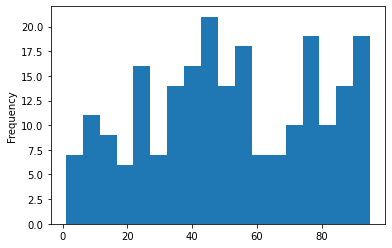

In [20]:
incidents_df['match_minute'] = incidents_df['match_minute'].apply(pd.to_numeric)
incidents_df['match_minute'].plot(kind='hist', bins = 18);

In [32]:
incidents_df[incidents_df['match_minute'] < 3]

,incident,team_decision,team,home_or_away,opposition,opposition_decision,date,year,month,match_minute,incident_penalty,incident_foul,incident_handball,incident_offside,incident_redcard,incident_yellowcard,players_involved,sum_incident_types
79,John McGinn goal disallowed for offside agains...,Against,Aston Villa,Away,Arsenal,For,Nov. 8,2020/2021,Nov,1.0,0,0,0,1,0,0,"[Barkley, Ross, John]",1.0
195,Penalty (scored by Pierre-Emerick Aubameyang) ...,For,Arsenal,Home,Watford,Against,Jul-26,2019/2020,Jul,2.0,1,1,0,0,0,0,"[Dawson, Craig, Lacazette, Aubameyang, Alexand...",2.0


In [38]:
# To standardize stoppage time incidents (to match with that of first half 45'), all incidents past 90min mark 
# (i.e. stoppage time) will be assigned the timing 90min
for i, row in incidents_df.iterrows():
    if row['match_minute'] > 90:
        incidents_df.loc[i, 'match_minute'] = 90

In [39]:
# Export to Tableau for better visualization
export_date = dt.today().strftime('%Y%m%d')
incidents_df.to_csv(f'./data/EPL_VAR_Incidents_Processed_{export_date}.csv', index = False)

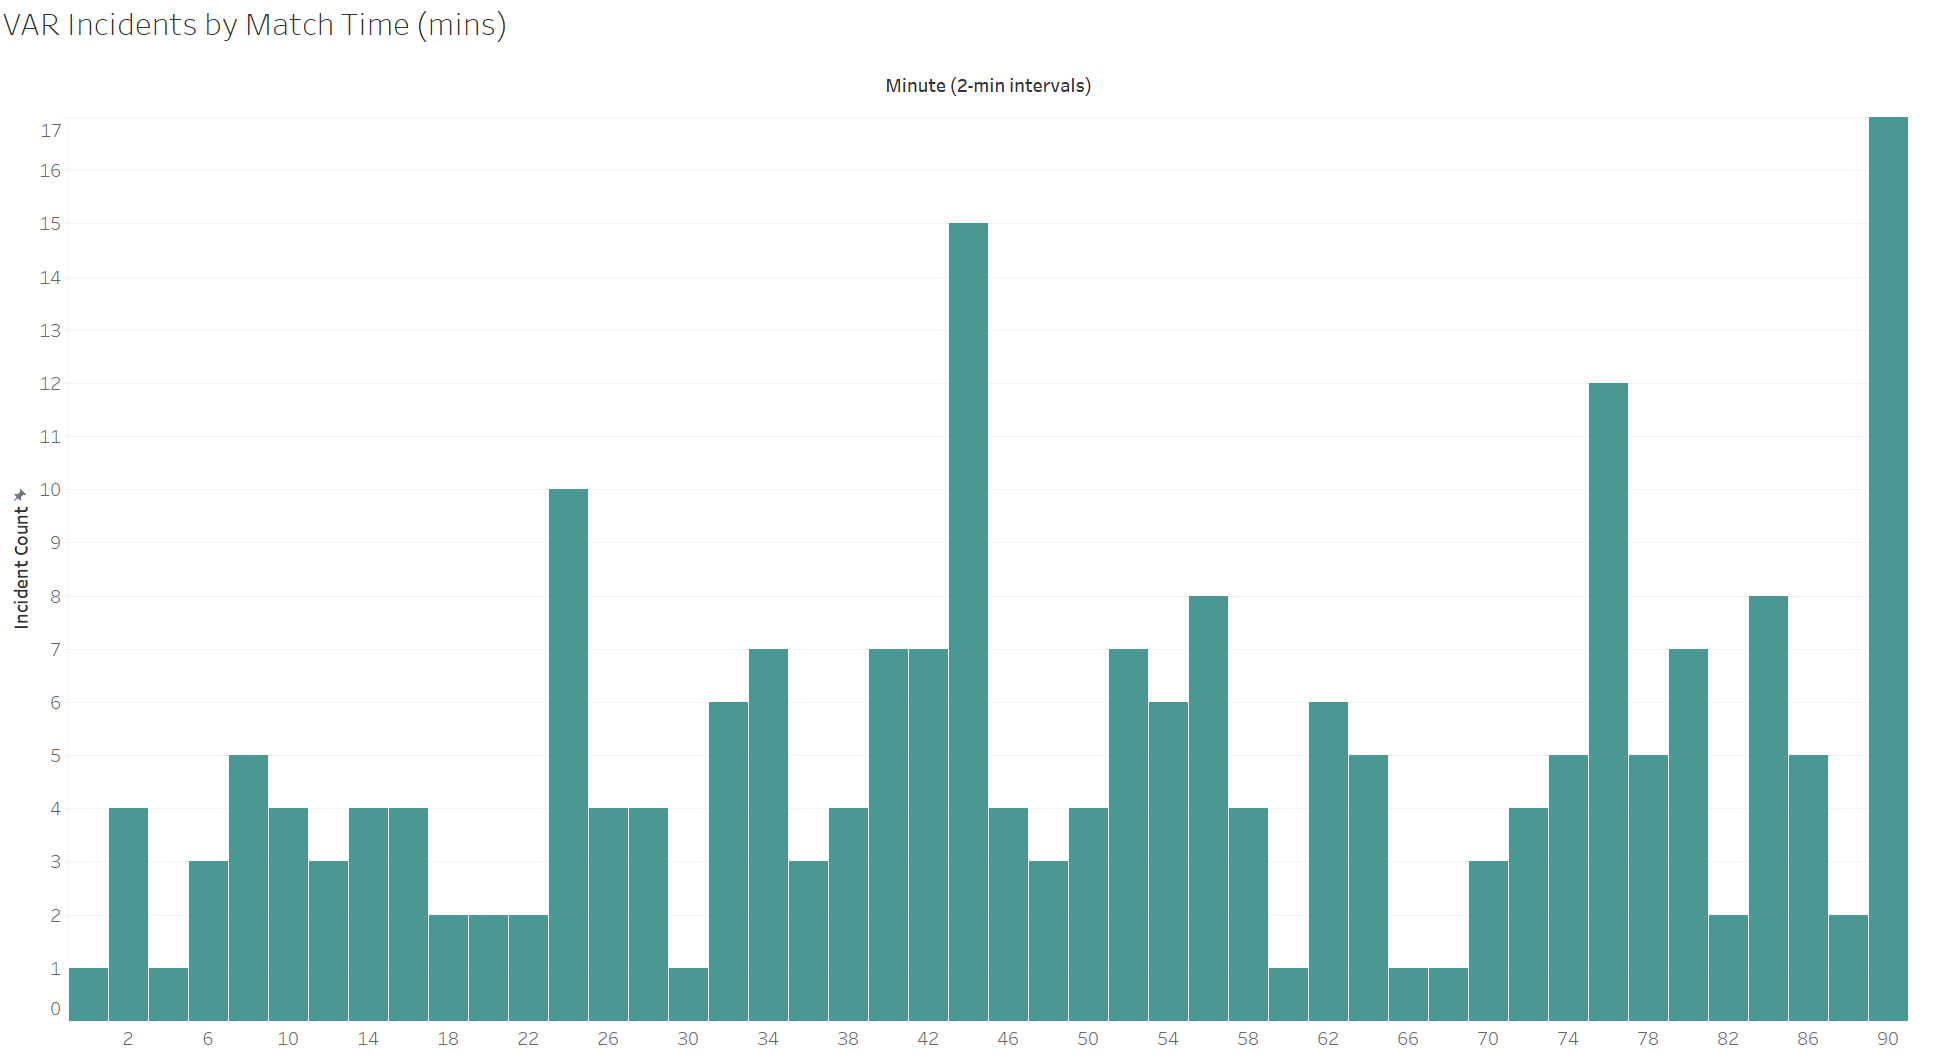

Some form of 'W' type trends seen for each half i.e. Spikes in VAR incidents in the middle and towards the end of the half

Incidents occurring at 45min and 90min mark include stoppage time incidents. This means that from the 46min onwards, incidents belong to the second half.

In [35]:
len(incidents_df[(incidents_df['match_minute'] >= 44) & (incidents_df['match_minute'] <=45)])

15